In [1]:
import networkx as nx
import matplotlib.pylab as plt
import numpy as np
import scipy.linalg as sp
import random
import cds_sticky3 as cd3
import graphml_loader as gl
import plotting_comparisons as pc
from add_weights_rf import add_weights_etx
import make_cds_routing_structure as mk
import cds_sticky2_refactor as cd

c_options = {
             0: 0.2611,
             1: 0.3085,
            }
c = c_options[1]

def calc_communicability(graph):
    return sp.expm(nx.adjacency_matrix(graph))    
    
def get_normalizing_factors(m):
    count = 0
    vals = np.zeros(m.shape[0])
    for i in m:
        factor = 0
        for j in i:
            factor += j
        vals[count] = factor
        count += 1
    return vals

def element_completeness(graph):
    m = calc_communicability(graph)
    n = get_normalizing_factors(m)
    ni = 1.0/(len(graph.nodes()))
    c = 0.3085
    vals = []
    for i in range(n.size):
        m[i, i] = np.real(m[i, i]/n[i])
        #m[i, i] = abs((1 - m[i,i])/(ni - 1))
        vals.append(m[i,i].tolist())
    return vals


def row_normal(graph):
    m = calc_communicability(graph)
    n = get_normalizing_factors(m)
    for i in range(n.size):
        m[i, i] = m[i, i]/n[i]
    return np.real(np.trace(array(m))/n.size).tolist()
 
def completeness(graph):
    h = row_normal(graph)
    ni = 1.0/len(graph.nodes())
    return abs((c - h)/(ni - c))

def run_things_generic(func, start, finish, graphs):
    values = []
    values_temp = [] 
    for i in range(finish - start):
        values_temp = []
        for j in graphs:
            values_temp.append(func(j[i]))
        values.append(values_temp)
    return values

In [2]:
start_pos = 0
finish_pos = 600

prob = 1.0 # Change to create random graphs with differing edge probabilities
nodes = 100

#Random Graphs
def gen_graphs(number):
    graphs = []
    for j in range(finish_pos - start_pos):
        graphs.append(nx.gnp_random_graph(nodes,number))
    return graphs



#Geometric graphs with increasing connectivity
def geo_connecting():
    graphs = []
    for i in range(finish_pos - start_pos):
        graphs.append(nx.random_geometric_graph(nodes, i / 1200.0 + 0.1))
    return graphs

#Chains of nodes
def hypothetical_worst_case():
    graphs = []
    for i in range(1,101):
        edge_list = [(j, j-1) for j in range(1, 4*i+2)]
        G = nx.Graph()
        G.add_edges_from(edge_list)
        graphs.append(G)
    return graphs
    
#4 chains of nodes originating from one central node
def hypothetical_worst_case_2_arms():
    graphs = []
    G = nx.Graph()
    G.add_edges_from([(0,1),(0,2),(0,3),(0,4)])
    graphs.append(G)
    for i in range(1,100):
        H = nx.Graph()
        H.add_edges_from([(0,1),(0,2),(0,3),(0,4)])
        b1 = [(4*j, 4*(j+1)) for j in range(1, i + 1)]
        b2 = [(4*j + 1, 4*(j+1) + 1) for j in range(i)]
        b3 = [(4*j + 2, 4*(j+1) + 2) for j in range(i)]
        b4 = [(4*j + 3, 4*(j+1) + 3) for j in range(i)]
        H.add_edges_from(b1)
        H.add_edges_from(b2)
        H.add_edges_from(b3)
        H.add_edges_from(b4)
        graphs.append(H)
    return graphs

# Complete Graph
def hypothetical_best_case():
    graphs = []
    for i in range(1,101):
        graphs.append(nx.complete_graph(4*(i) + 1))
    return graphs   

# Java Sea Scenario
def java_sea_scenarios():
    graphs = gl.load_graphs(scenario_directory = "scenarios/JavaScenario/output/FadingModel/JavaScenarioprocessed", start = start_pos, finish = finish_pos, threshold_func = add_weights_etx, threshold_factor = 'linkSuccessWeight', filter_weights = True) 
    return graphs

def grid_clusters():
    graphs = gl.load_graphs(scenario_directory = "scenarios/gridClusters/output/gridClustersprocessed", start = start_pos, finish = finish_pos, threshold_func = add_weights_etx, filter_weights = True)
    return graphs

In [3]:
graph_choice = java_sea_scenarios() # set to a list of graphs, if you're going to look at CDS metrics of that graph
graph_choice_2 = grid_clusters()
graph_choice_3 = hypothetical_worst_case()

#CDS with other nodes as leaves
def cds_struct(graphs):
    old_relays = set()
    graphs_cds = []
    for graph in graphs:
        temp = mk.make_cds_routing_structure(graph, lambda x: cd.find_ecds_sticky(x, old_relays, with_degree = True, with_sticky = True, weighted_deg = True))
        graphs_cds.append(temp[0])
        old_relays = temp[2]
    return graphs_cds

def just_cds(graphs):
    old_relays = set()
    graphs_cds = []
    for graph in graphs:
        old_relays = cd.find_ecds_sticky(graph, old_relays, with_degree = True, with_sticky = True, weighted_deg = True)
        graphs_cds.append(graph.subgraph(old_relays))
    return graphs_cds

def just_cds_2(graphs):
    old_relays = set()
    graphs_cds = []
    for graph in graphs:
        old_relays = cd.find_ecds_sticky(graph, old_relays, with_degree = True, with_sticky = False, weighted_deg = True)
        graphs_cds.append(graph.subgraph(old_relays))
    return graphs_cds

def just_cds_3(graphs):
    old_relays = set()
    graphs_cds = []
    for graph in graphs:
        old_relays = cd.find_ecds_sticky(graph, old_relays, with_degree = False, with_sticky = False, weighted_deg = True)
        graphs_cds.append(graph.subgraph(old_relays))
    return graphs_cds

def just_cds_4(graphs):
    old_relays = set()
    graphs_cds = []
    for graph in graphs:
        old_relays = cd3.choose_stuff(graph, old_relays)
        graphs_cds.append(graph.subgraph(old_relays))
    return graphs_cds

graphs_to_analyze = [graph_choice,  just_cds(graph_choice), just_cds_2(graph_choice), just_cds_4(graph_choice)] #Replace this with a list of graphs to analyze

#nx.draw()

Percent Loaded: 100%                                                           
Percent Loaded: 100%                                                           
/Users/macker/anaconda/lib/python2.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:228: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


ValueError: setting an array element with a sequence.

In [ ]:
values_nnc = run_things_generic(completeness, start_pos, finish_pos, graphs_to_analyze)

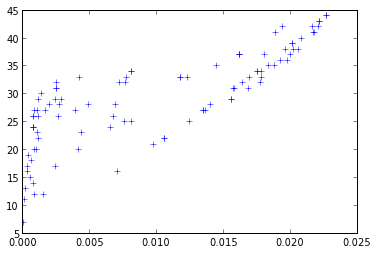

[[ 1.          0.42395167]
 [ 0.42395167  1.        ]]


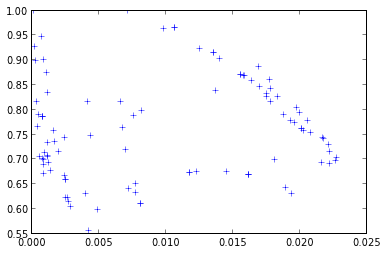

[[ 1.          0.08488974]
 [ 0.08488974  1.        ]]


In [9]:
%matplotlib inline
G = graph_choice[0]
m = nx.adjacency_matrix(graph_choice[0])
d1 = []
for i in range(m[0,:].size):
    s2 = 0
    for j in range(m[i,:].size):
        s2 += m[i,j]
    d1.append(s2)

ec = element_completeness(graph_choice[0])
degrees = graph_choice[0].degree(graph_choice[0])
d2 = []
for i in degrees.keys():
    d2.append(degrees[i])
#print d1
#print d2


plt.plot(ec, d1, "+")
plt.show()

var = array([d1,d2])
print numpy.corrcoef(var)

c = nx.clustering(G)

cs = []
for i in G.nodes():
    cs.append(c[i])

plt.plot(ec, cs, "+")
plt.show()

var = array([cs,ec])
print numpy.corrcoef(var)

'''
def average_nodes(graphs):
    avg = 0
    for i  in graphs:
        avg += len(i.nodes())
    return avg / len(graphs)
    
print nx.adjacency_matrix(graphs_to_analyze[0][0], weight = 'weight')
print nx.info(graphs_to_analyze[0][0])
print graphs_to_analyze[0][0].nodes()
#H = add_weights_etx(graphs_to_analyze[0][0], link_weight = 'linkSuccessRate', )
print nx.get_edge_attributes(graphs_to_analyze[0][0], 'linkSuccessRate')
   
print "_"*40
print "Average Amount of Nodes(SE-CDS): " + str(average_nodes(graphs_to_analyze[1]))
print "Average Amount of Nodes(E-CDS): " + str(average_nodes(graphs_to_analyze[2]))
print "Average Amount of Nodes(CE-CDS): " + str(average_nodes(graphs_to_analyze[3]))
print "_"*40
''';

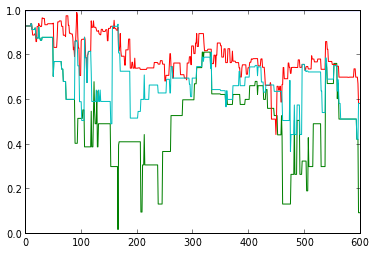

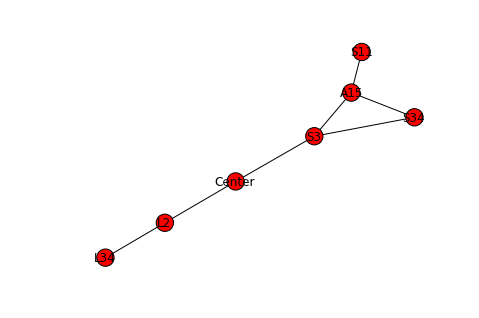

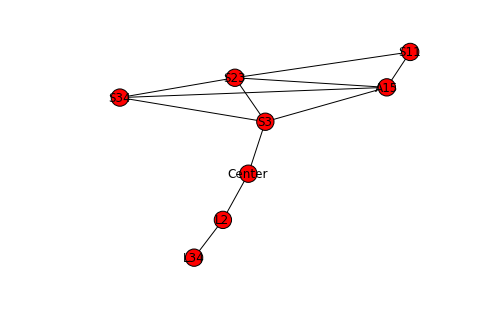

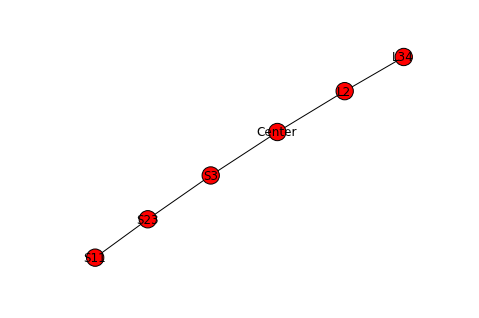

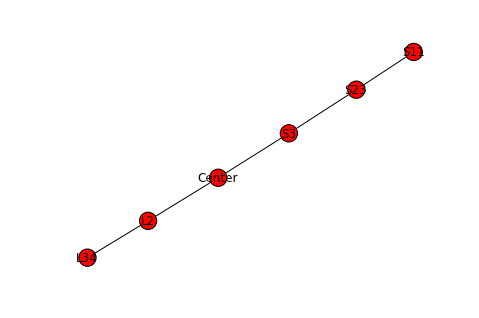

In [16]:
#Blue: Overall Completeness
#Red: E-CDS
#Green: SE-CDS
#Cyan / Light Blue:  CDS3

plt.plot(values_nnc)
plt.show()


#graphs for seconds 433 to 439, the bulk of the "outlying" period on the graph
for i in range(165, 169):
    nx.draw(graphs_to_analyze[1][i])
    plt.show()


In [ ]:
def estimate_c():
    c = 0
    new_c = 0
    count = 0
    for i in range(2, 102):
        edge_list = [(j, j-1) for j in range(1, i+1)]
        G = nx.Graph()
        G.add_edges_from(edge_list)
        G.add_edges_from([(0,i)])
        #nx.draw(G)
        #plt.show()
        new_c = row_normal(G)
        #if count == 10:
       # print "*" * 40
        #print new_c
        #print new_c - c
        #print "*" * 40
        #print
        #count = 0
        c = new_c
        #count += 1

estimate_c()    
        

In [24]:
'''
Network Attack / Compare Completeness to Fiedler
'''


        
# Case 1 Remove nodes at random and measure fiedler values
def run_random_attack(RG, weak_threshold = 0.001):
    count = 0
    print "working attack 1"
    random_success = []
    R_fiedler_array = []
    R_completeness = []
    R_fiedler = 1.0
    while R_fiedler > weak_threshold and len(RG) > 2:
        A=nx.generalized_laplacian(RG)
        eigenvalues,eigenvectors=numpy.linalg.eigh(A)	
        esorted=numpy.sort(eigenvalues)
        R_fiedler = esorted[1]
        R_fiedler_array.append(R_fiedler)
        R_completeness.append(completeness(RG))
        count = count + 1
        kill_node=random.choice(RG.nodes())
        RG.remove_node(kill_node)
    random_success.append(count)
    nx.draw(RG)
    plt.show()
    return random_success, R_fiedler_array, R_completeness


def run_fiedler_attack(FG, weak_threshold = 0.001):
    print "working attack 2"
    count = 0
    F_fiedler_array = []
    F_completeness = []
    focused_success = []
    F_fiedler = 1.0 
    while F_fiedler > weak_threshold and len(FG) > 2:
        A=nx.generalized_laplacian(FG)
        eigenvalues,eigenvectors=numpy.linalg.eigh(A)	
        l=numpy.argsort(eigenvalues)
        esorted=numpy.sort(eigenvalues)
        F_fiedler = esorted[1]      
        F_fiedler_array.append(F_fiedler)
        F_completeness.append(completeness(FG))
        indexed = numpy.argsort(eigenvectors[:,l[1]])
        F_list = FG.nodes()
        count = count + 1
        minindex = numpy.argmin(eigenvectors[:,l[1]])
        fiedler_vector = eigenvectors[:,l[1]]
        listindex = numpy.argsort(eigenvectors[:,l[1]])
        lowone = listindex[0]
        kill_node=F_list[minindex]
        FG.remove_node(kill_node)
    focused_success.append(count)
    nx.draw(FG)
    plt.show()
    return focused_success, F_fiedler_array, F_completeness

def run_max_attack(MG, weak_threshold = 0.001):
    count = 0
    M_fiedler_array = []
    M_completeness = []
    max_success = []
    M_fiedler = 1.0
    print "working attack 3"        
    while M_fiedler > weak_threshold and len(MG) > 2:
        A=nx.generalized_laplacian(MG)
        eigenvalues,eigenvectors=numpy.linalg.eigh(A)	
        l=numpy.argsort(eigenvalues)
        esorted=numpy.sort(eigenvalues)
        M_fiedler = esorted[1]
        M_fiedler_array.append(M_fiedler) 
        M_completeness.append(completeness(MG))
        indexed = numpy.argsort(eigenvectors[:,l[-1]])
        F_list = MG.nodes()
        count = count + 1
        maxindex = numpy.argmax(eigenvectors[:,l[-1]])
        fiedler_vector = eigenvectors[:,l[1]]
        listindex = numpy.argsort(eigenvectors[:,l[-1]])
        kill_node=F_list[maxindex]
        MG.remove_node(kill_node)
    max_success.append(count)
    nx.draw(MG)
    plt.show()
    return max_success, M_fiedler_array, M_completeness

def run_google_attack(GG, weak_threshold = 0.001):
    count = 0
    G_fiedler_array = []
    G_completeness = []
    ranking_success = []
    G_fiedler = 1.0
    print "working attack 4"
    while G_fiedler > weak_threshold and len(GG) > 2:
        A=nx.generalized_laplacian(GG)
        eigenvalues,eigenvectors=numpy.linalg.eigh(A)	
        l=numpy.argsort(eigenvalues)
        esorted=numpy.sort(eigenvalues)
        G_fiedler = esorted[1]
        G_fiedler_array.append(G_fiedler)
        G_completeness.append(completeness(GG))
        count = count + 1
        rankings = make_dict(GG, bridging_coefficient_node(GG))
        kill_node = max(rankings,key = lambda a: rankings.get(a))
        GG.remove_node(kill_node)
    ranking_success.append(count)
    pos = {}
    for n,d in GG.nodes(data=True):
        if 'location_x' in d:
            pos[n] = d['location_x'],d['location_y']
        elif 'location_longitude' in d:
            pos[n] = d['location_longitude'],d['location_latitude']
        else:
            print "found no location data"
            pos = nx.spring_layout(GG)
            break
    nx.draw(GG, pos = pos)
    plt.show()
    return ranking_success, G_fiedler_array, G_completeness

def run_markov_attack(GG, weak_threshold = 0.001):
    count = 0
    G_fiedler_array = []
    G_completeness = []
    ranking_success = []
    G_fiedler = 1.0
    print "working attack 4"
    while G_fiedler > weak_threshold and len(GG) > 2:
        A=nx.generalized_laplacian(GG)
        eigenvalues,eigenvectors=numpy.linalg.eigh(A)	
        l=numpy.argsort(eigenvalues)
        esorted=numpy.sort(eigenvalues)
        G_fiedler = esorted[1]
        G_fiedler_array.append(G_fiedler)
        G_completeness.append(completeness(GG))
        count = count + 1
        rankings = make_dict(GG, calc_markov_centrality(GG))
        kill_node = max(rankings,key = lambda a: rankings.get(a))
        GG.remove_node(kill_node)
    ranking_success.append(count)
    pos = {}
    for n,d in GG.nodes(data=True):
        if 'location_x' in d:
            pos[n] = d['location_x'],d['location_y']
        elif 'location_longitude' in d:
            pos[n] = d['location_longitude'],d['location_latitude']
        else:
            print "found no location data"
            pos = nx.spring_layout(GG)
            break
    nx.draw(GG, pos = pos)
    plt.show()
    return ranking_success, G_fiedler_array, G_completeness

def run_degree_attack(GG, weak_threshold = 0.001):
    count = 0
    G_fiedler_array = []
    G_completeness = []
    ranking_success = []
    G_fiedler = 1.0
    print "working attack 4"
    while G_fiedler > weak_threshold and len(GG) > 2:
        A=nx.generalized_laplacian(GG)
        eigenvalues,eigenvectors=numpy.linalg.eigh(A)	
        l=numpy.argsort(eigenvalues)
        esorted=numpy.sort(eigenvalues)
        G_fiedler = esorted[1]
        G_fiedler_array.append(G_fiedler)
        G_completeness.append(completeness(GG))
        count = count + 1
        rankings = nx.degree(GG)
        kill_node = max(rankings,key = lambda a: rankings.get(a))
        GG.remove_node(kill_node)
    ranking_success.append(count)
    pos = {}
    for n,d in GG.nodes(data=True):
        if 'location_x' in d:
            pos[n] = d['location_x'],d['location_y']
        elif 'location_longitude' in d:
            pos[n] = d['location_longitude'],d['location_latitude']
        else:
            print "found no location data"
            pos = nx.spring_layout(GG)
            break
    nx.draw(GG, pos = pos)
    plt.show()
    return ranking_success, G_fiedler_array, G_completeness

def run_betweenness_attack(GG, weak_threshold = 0.001):
    count = 0
    G_fiedler_array = []
    G_completeness = []
    ranking_success = []
    G_fiedler = 1.0
    print "working attack 4"
    while G_fiedler > weak_threshold and len(GG) > 2:
        A=nx.generalized_laplacian(GG)
        eigenvalues,eigenvectors=numpy.linalg.eigh(A)	
        l=numpy.argsort(eigenvalues)
        esorted=numpy.sort(eigenvalues)
        G_fiedler = esorted[1]
        G_fiedler_array.append(G_fiedler)
        G_completeness.append(completeness(GG))
        count = count + 1
        rankings = nx.betweenness_centrality(GG)
        kill_node = max(rankings,key = lambda a: rankings.get(a))
        GG.remove_node(kill_node)
    ranking_success.append(count)
    pos = {}
    for n,d in GG.nodes(data=True):
        if 'location_x' in d:
            pos[n] = d['location_x'],d['location_y']
        elif 'location_longitude' in d:
            pos[n] = d['location_longitude'],d['location_latitude']
        else:
            print "found no location data"
            pos = nx.spring_layout(GG)
            break
    nx.draw(GG, pos = pos)
    plt.show()
    return ranking_success, G_fiedler_array, G_completeness

def run_bridgec_attack(GG, weak_threshold = 0.001):
    count = 0
    G_fiedler_array = []
    G_completeness = []
    ranking_success = []
    G_fiedler = 1.0
    print "working attack 4"
    while G_fiedler > weak_threshold and len(GG) > 2:
        A=nx.generalized_laplacian(GG)
        eigenvalues,eigenvectors=numpy.linalg.eigh(A)	
        l=numpy.argsort(eigenvalues)
        esorted=numpy.sort(eigenvalues)
        G_fiedler = esorted[1]
        G_fiedler_array.append(G_fiedler)
        G_completeness.append(completeness(GG))
        count = count + 1
        rankings = make_dict(GG, bridging_centrality_node(GG))
        kill_node = max(rankings,key = lambda a: rankings.get(a))
        GG.remove_node(kill_node)
    ranking_success.append(count)
    pos = {}
    for n,d in GG.nodes(data=True):
        if 'location_x' in d:
            pos[n] = d['location_x'],d['location_y']
        elif 'location_longitude' in d:
            pos[n] = d['location_longitude'],d['location_latitude']
        else:
            print "found no location data"
            pos = nx.spring_layout(GG)
            break
    nx.draw(GG, pos = pos)
    plt.show()
    return ranking_success, G_fiedler_array, G_completeness


In [25]:
'''
Run Code
'''
import numpy
from numpy import *
G = graph_choice[0]

RG = G.copy()
FG = G.copy()
MG = G.copy()
GG = G.copy()

r_s, r_f, r_c = run_markov_attack(RG)
f_s, f_f, f_c = run_bridging_attack(FG)
m_s, m_f, m_c = run_betweenness_attack(MG)
g_s, g_f, g_c = run_bridgec_attack(GG)

num_trials = 10
weak_threshold = 0.01
number_per_round = 1


print
print "Random Attack: Average time= %d Stddev = %d" % (numpy.average(r_s), numpy.std(r_s))
print "Fiedler Min Attack: Average time= %d Stddev = %d" % (numpy.average(f_s), numpy.std(f_s))
print "Max eigenvalue max vector Attack: Average time= %d Stddev = %d" % (numpy.average(m_s), numpy.std(m_s))
print "Pagerank Attack: Average time= %d Stddev = %d" % (numpy.average(g_s), numpy.std(g_s))
print
    

rt = range(len(r_f))
ft = range(len(f_f))
mt = range(len(m_f))
gt = range(len(g_f))
plt.title ("Measure of Network Attack %s" % "Java Sea",fontsize = 24)
plt.ylabel("Fiedler Value",fontsize=24)
plt.xlabel("Attack Time Steps ->",fontsize=24)
plt.plot(rt, r_f,'r:', ft, f_f,'b--',mt, m_f,'g--',gt, g_f,'c-', linewidth = 2)
plt.legend(('Random', 'Fiedler', 'MaxEigen', 'PageRank'),'upper left', shadow=True)
plt.axvline(max(rt), color='red', lw=2)	
plt.axvline(max(ft), color='blue', lw=2)	
plt.axvline(max(mt), color='green', lw=2)	
plt.axvline(max(gt), color='cyan', lw=2)
plt.axis([0,len(G),0.0,0.3])
plt.show()




# the histogram of the data
#n, bins, patches = plt.hist(random_success, num_trials, normed=1, facecolor='green', alpha=0.50)
#n, bins, patches = plt.hist(focused_success, num_trials, normed=1, facecolor='blue', alpha=0.50)
#n, bins, patches = plt.hist(max_success, 10, facecolor='red', alpha=0.50)
#n, bins, patches = plt.hist(ranking_success, num_trials, normed=1, facecolor='cyan', alpha=0.50)
#plt.show()   


TypeError: unsupported operand type(s) for -: 'dict' and 'float'

working attack 1


In [26]:
import wu_li as wl
import cds_tool1 as ct
reload(ct)

g = graph_choice[0]
s1 = wl.get_wu_li(g, v2 = True)
s2 = cd.find_ecds_sticky(g, set(), with_degree = True, with_sticky = False, weighted_deg = True)
s3 = ct.wu_li_weighted(g)
s4 = ct.wu_li_weighted(g, weights = True, sticky = True, rel = set(), delta = 5)

pos = {}
for n,d in g.nodes(data=True):
        if 'location_x' in d:
            pos[n] = d['location_x'],d['location_y']
        elif 'location_longitude' in d:
            pos[n] = d['location_longitude'],d['location_latitude']
        else:
            print "found no location data"
            pos = nx.spring_layout(g)
            break

'''            
figsize(20,20)
nx.draw_networkx_nodes(g, pos, nx.nodes(g), node_size=150, node_color="b", alpha = 0.5)
nx.draw_networkx_nodes(g, pos, s2, node_size=200, node_color="r")
nx.draw_networkx_edges(g, pos, edgelist=None, width=0.5, edge_color="b",style= "dashed", alpha=0.5)
nx.draw_networkx_edges(g.subgraph(s2), pos, edgelist=None, width=1.0, edge_color="r", style="solid")
leg = 'Number of Relays = %i' % len(s2)
text(4, 4, leg)
ylabel("Y Location (Meters)")
xlabel("X Location (Meters)")
axis('off')

plt.show()



nx.draw_networkx_nodes(g, pos, nx.nodes(g), node_size=150, node_color="b", alpha = 0.5)
nx.draw_networkx_nodes(g, pos, s1, node_size=200, node_color="r")
nx.draw_networkx_edges(g, pos, edgelist=None, width=0.5, edge_color="b",style= "dashed", alpha=0.5)
nx.draw_networkx_edges(g.subgraph(s1), pos, edgelist=None, width=1.0, edge_color="r", style="solid")
leg = 'Number of Relays = %i' % len(s1)
text(4, 4, leg)
ylabel("Y Location (Meters)")
xlabel("X Location (Meters)")
axis('off')
plt.show()

nx.draw_networkx_nodes(g, pos, nx.nodes(g), node_size=150, node_color="b", alpha = 0.5)
nx.draw_networkx_nodes(g, pos, s3, node_size=200, node_color="r")
nx.draw_networkx_edges(g, pos, edgelist=None, width=0.5, edge_color="b",style= "dashed", alpha=0.5)
nx.draw_networkx_edges(g.subgraph(s3), pos, edgelist=None, width=1.0, edge_color="r", style="solid")
leg = 'Number of Relays = %i' % len(s3)
text(4, 4, leg)
ylabel("Y Location (Meters)")
xlabel("X Location (Meters)")
axis('off')
plt.show()

nx.draw_networkx_nodes(g, pos, nx.nodes(g), node_size=150, node_color="b", alpha = 0.5)
nx.draw_networkx_nodes(g, pos, s4, node_size=200, node_color="r")
nx.draw_networkx_edges(g, pos, edgelist=None, width=0.5, edge_color="b",style= "dashed", alpha=0.5)
nx.draw_networkx_edges(g.subgraph(s4), pos, edgelist=None, width=1.0, edge_color="r", style="solid")
leg = 'Number of Relays = %i' % len(s4)
text(4, 4, leg)
ylabel("Y Location (Meters)")
xlabel("X Location (Meters)")
axis('off')
plt.show()
''';

ImportError: No module named cds_tool1

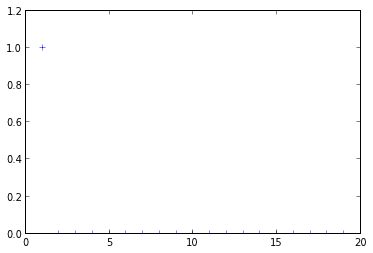

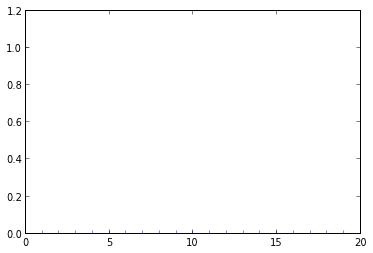

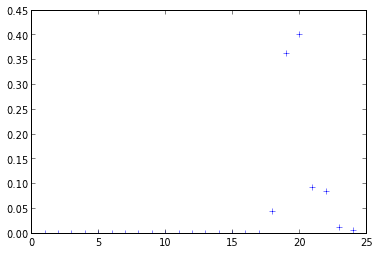

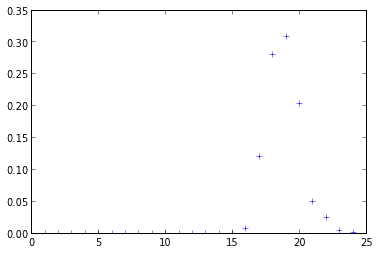

In [31]:
'''
Probalistic Distributions
'''

#simple moving average
#TBD

#takes a set of data and creates a distribution of the data with probalities for intervals equal to size
def calc_distribution(data, size):
    p = numpy.zeros((1, 1.0/size))
    for i in data:
        p[0, math.floor(i/size)] += 1.0/len(data)
    return p.tolist()[0]

#takes a set of data and creates a distribution of the data with probabilites with size intervals between max and min
def calc_num_distribution(data, size):
    p = numpy.zeros((1, size))
    max_val = max(data)
    #min_val = min(data)
    interval = (max_val)*1.0/(size - 1)
    for i in data:
        p[0, math.floor(i/interval)] += 1.0/len(data)
    return p.tolist()[0]

G = graph_choice[0]

degrees = nx.degree_centrality(G)
d1 = []
for i in G.nodes():
    d1.append(degrees[i])


ec = element_completeness(G)

'''  
pk = calc_distribution(d1, 0.05)
pc = calc_distribution(ec, 0.05)
#print pk
#print pc

plt.plot(range(len(pk)), pk, '+')
plt.show()

plt.plot(range(len(pc)), pc, '+')
plt.show()
    
pnk = calc_num_distribution(d1, 25)
pnc = calc_num_distribution(ec, 25)
#print pnk
#print pnc

plt.plot(range(len(pnk)), pnk, '+')
plt.show()

plt.plot(range(len(pnc)), pnc, "+")
plt.show()
''';
    

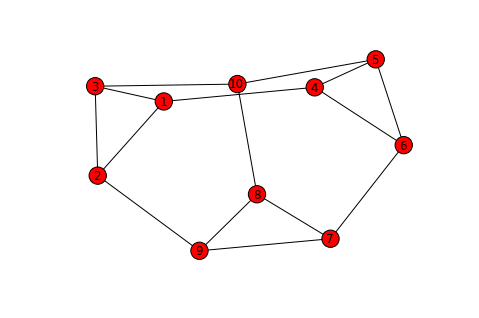

In [96]:
G = graph_choice[0]
H = graph_choice_2[0]
I = nx.gnp_random_graph(50, .25)
J = graph_choice_3[50]
K = nx.Graph()
K.add_edges_from([(1,2), (1,3), (1,4), (2, 3), (2, 9), (3,10), (4, 5), (4, 6), (5, 6), (5, 10), (6, 7), (7, 8), (7, 9), (8,9), (8, 10)])
nx.draw(K)
plt.show()
Z = nx.karate_club_graph()
def check_frobenius_perron(graph):
    a = nx.adjacency_matrix(graph)
    y, v = np.linalg.eig(a)
    
    bools = []
    for i in range(y.size):
        good = True
        for j in range(y.size):
            if v[j, i] > 0:
                good = False
        bools.append(good)
    print bools

#check_frobenius_perron(G)

def print_vectors(graph):
    a = nx.adjacency_matrix(graph)
    y, v = np.linalg.eig(a)
    l = np.argsort(y)
    esorted = np.sort(y)
    print l[y.size - 1]
    print y[0]
    for j in range(y.size):
        print ('%.2f' % np.real(v[j, 0]).tolist()),
    print
    
#print_vectors(G)

def calc_scodd(graph):
    a = nx.adjacency_matrix(graph)
    y, v = np.linalg.eigh(a)
    '''
    esorted=np.sort(y)
    l = np.argsort(y)
    l1 = np.real(esorted[esorted.size - 1])
    v = np.real(v)
    v1 = v[:, l[y.size - 1]]
    v1 = abs(v1)
    c = [i**2 * np.sinh(l1) for i in v1.flat]
    r = []
    for i in range(v1.size):
        s = 0
        for j in range(v1.size - 1):
            s += v[i, j]**2*np.sinh(esorted[j])
        r.append(np.log10(abs(c[i] + s)))
    return r, [np.log10(i) for i in v1.flat], np.log10(np.sinh(l1))
    '''
    vals = []
    for i in range(y.size):
        s = 0
        for j in range(y.size):
            s += v[i, j]**2*np.sinh(np.real(y[j]))
        vals.append(abs(s))
    return vals

def calc_estrada_correlation(graph):
    r, c, l1 = calc_scodd(graph)
    return np.corrcoef(np.array([r,c]))[0,1]**2
   
    

def calc_estrada_xi(graph):
    temp = 0.0
    r, c, l1 = calc_scodd(graph)
    #plt.plot(r, c, "+")
    #plt.show()
    for i in range(len(r)):
        temp += (c[i] - ((l1)**(-0.5) + 0.5 * r[i])) ** 2
    xi = (temp*1.0/len(r))**0.5
    print xi
    
#print calc_estrada_correlation(Z)
#calc_estrada_xi(Z)   
#print calc_scodd(J)

def calc_estrada_vals(graph):
    a = nx.adjacency_matrix(graph)
    y, v = np.linalg.eigh(a)
    esorted=np.sort(y)
    l = np.argsort(y)
    l1 = np.real(esorted[esorted.size - 1])
    v1 = v[:, l[y.size - 1]]
    v1 = np.real(v1)
    v1 = abs(v1)
    x = [(np.log10(i)) for i in v1.flat]
    y = [(np.log10(i**2 * np.sinh(l1))) for i in v1.flat]
    plt.plot(y, x, "+")
    plt.show()
    zp = [2*(np.log10(i)) / (np.log10(i**2 * np.sinh(l1)) - np.log10(np.sinh(l1))) for i in v1.flat]
    print zp
    plt.plot(zp, "+")
    plt.show()

#calc_estrada_vals(J)
   


In [ ]:
#L = nx.gnp_random_graph(50, 0.8)

def calc_markov_mean_first_passage(G):
    '''
    Stock Matrices / Vectors
    '''
    dim = len(G.nodes())
    A = nx.adjacency_matrix(G)
    E = np.ones((dim, dim))
    I = np.identity(dim)
    e = np.ones(dim)
    '''
    Derived Matrices / Vectors
    '''
    y, v = np.linalg.eigh(A)
    index = 0
    for i in range(dim):
        if y[i] == 1:
            index = np.argsort[i]
    temp = v[:, index].tolist()
    pi = np.ones(dim)
    for i in range(dim):
        pi[i] = abs(temp[i][0])
    Z = np.linalg.inv(I - A - (e*pi).T)
    Zdg = np.zeros((dim, dim))
    D = np.zeros((dim, dim))
    for i in range(dim):
        Zdg[i, i] = Z[i, i]
        D[i, i] = 1.0/pi[i]
    '''
    Matrix
    '''
    M = np.dot((I - Z + np.dot(E, Zdg)), D)
    return M

def calc_markov_centrality(G):
    M = calc_markov_mean_first_passage(G)
    dim = len(G.nodes())
    vals = []
    for i in range(dim):
        vals.append(dim * 1.0 / sum([M[i, j] for j in range(dim)]))
    n = sum([abs(i) for i in vals])
    for i in range(dim):
        vals[i] = vals[i] * 1.0 / n
    return vals

def get_degrees(G):
    degrees = nx.degree_centrality(G)
    d1 = []
    for i in G.nodes():
        d1.append(degrees[i])
    return d1

def delta(G, node, neighbor):
    N =set(nx.all_neighbors(G, node))
    out = set(nx.all_neighbors(G, neighbor))
    return len(out) - len(out & N) - 1
    
def bridging_coefficient_node(G):
    d = nx.degree(G)
    coefficients = []
    for i in G.nodes():
        x = 0
        for N in nx.all_neighbors(G, i):
            x += delta(G, i, N) * 1.0/(d[N] - 1)
        coefficients.append(1.0/d[i] * x)
    return coefficients

def bridging_centrality_node(G):
    vals1 = []
    vals2 = bridging_coefficient_node(G)
    nodes = G.nodes()
    temp = nx.betweenness_centrality(G)
    for i in nodes:
        vals1.append(temp[i])
    max_1 = max(vals1)
    max_2 = max(vals2)
    ret = []
    for i in range(len(nodes)):
        ret.append(vals1[i]*1.0/max_1*vals2[i]*1.0/max_2)
    return ret
    

def make_dict(G, vals):
    nodes = list(G.nodes())
    return {nodes[i] : vals[i] for i in range(len(nodes))}

#Needed?
def bridiging_coefficient_edge(G):
    print "Not Done"
    
    
#bridging_coefficient_node(G)

def calc_katz_centrality(G):
    A = nx.adjacency_matrix(G)
    dim = len(G.nodes())
    y, v = np.linalg.eigh(A)
    I = np.identity(dim)
    y.sort()
    alpha = .95/(y[dim - 1])
    C = np.linalg.inv(I - alpha * A)
    vals = []
    for i in range(dim):
        vals.append(C[i, i])
    return vals
K = nx.Graph()
K.add_edges_from([(1,2), (1,3), (1,4), (2, 3), (2, 9), (3,10), (4, 5), (4, 6), (5, 6), (5, 10), (6, 7), (7, 8), (7, 9), (8,9), (8, 10)])
nx.draw(K)
plt.show()

G = nx.gnp_random_graph(10, 0.5)

print calc_katz_centrality(K)
